In [73]:
import pandas as pd
import numpy as np
import requests, os
import time
from matplotlib import pyplot
%matplotlib inline  

lags_to_forecast = 10
print("done")

done


            Value
Time             
2017-01-01   2.35
2017-01-02   2.36
2017-01-03   2.37
2017-01-04   2.38
2017-01-05   2.38


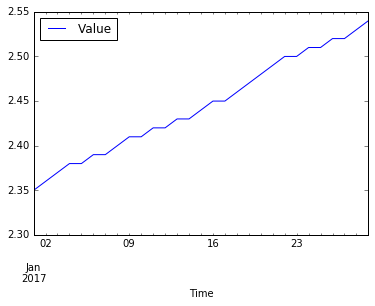

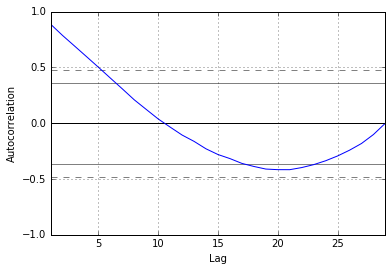

In [74]:
#This is just a sample
series = pd.read_csv('SampleData.csv', header=0, index_col = 0, parse_dates=[0])
print(series.head())
series.plot()
pyplot.show()

from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)


from statsmodels.tsa.arima_model import ARIMA
# fit model
#series2 = series.astype(float)
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)

#print(model_fit.summary())

/Users/yanniel/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/yanniel/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/yanniel/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/yanniel/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/yanniel/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization f

Best model (p,d,q) : (4,2,3)


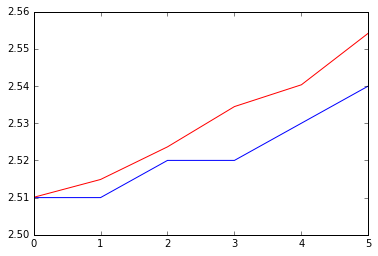

[2.5442335747373925, 2.554016365044717, 2.5575036896848133, 2.5659371242989373, 2.5714015573741951, 2.5778573894378565, 2.5849406730043256, 2.5903438287061591, 2.5977914740714096, 2.6033230427371459]
done


/Users/yanniel/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [81]:
#ARIMA model - using only previous data.  This code will split the data into a train and test set
#find the best ARIMA model based on squared error terms, and predict the next 5 data points
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


RawData = pd.read_csv('SampleData.csv', header=0, index_col = 0, parse_dates=[0])
RawData.columns = ["price"]
#print(RawData)
RawData = RawData.values
size = int(len(RawData) * 0.8)
forecast_size = len(RawData)- size
#split data into training and test sets
train, test = RawData[0:size], RawData[size:len(RawData)]
train = [x for x in train]
test = [x[0] for x in test]
#print(train)

bestp, bestd, bestq = -1, -1, -1
best_error = 1000000
forecasted_values = []
for p in range(0,5):
    for d in range(0,5):
        for q in range(0,5):
            try:
                #print(p,d,q)
                model = ARIMA(train, order=(p,d,q))
                model_fit = model.fit(disp=0, transparams = True)  # Add transparams = True, returns statsmodels.tsa.arima.ARIMAResults class
                forecasted_values = [x for x in model_fit.forecast(forecast_size)[0]]
                error = mean_squared_error(y_true = test, y_pred = forecasted_values)
                if error < best_error:
                    bestp = p
                    bestd = d
                    bestq = q
            except:
                pass

print("Best model (p,d,q) : (" + str(bestp) + "," + str(bestd) + "," + str(bestq) + ")")

# plot
if not(bestp == -1 or bestd == -1 or bestq == -1):
    pyplot.plot(test)
    pyplot.plot(forecasted_values, color='red')
    pyplot.show()
    
    #Predict the next few lags
    model = ARIMA(RawData, order=(bestp,bestd,bestq))
    model_fit = model.fit(disp=0, transparams = True)
    forecasted_values = [x for x in model_fit.forecast(lags_to_forecast)[0]]
    print(forecasted_values)
    
print("done")

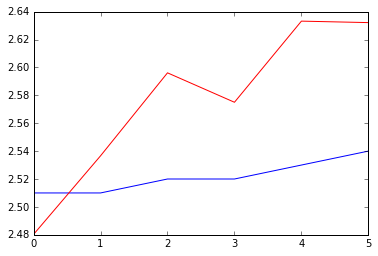

Best model: Var(19)
[2.5590994137883949, 2.5807799918564256, 2.5561650246626919, 2.5856307861254559, 2.6149503223399821, 2.6113155170946731, 2.6723781197826573, 2.6355314434321806, 2.6404933003933788, 2.6165160902641471]


In [76]:
from statsmodels.tsa.api import VAR, DynamicVAR

RawData = pd.read_csv('SampleData1.csv', header=0, index_col = 0, parse_dates=[0])
RawData.columns = ["price", "var1"]
size = int(len(RawData) * 0.8)
forecast_size = len(RawData)- size

#split data into training and test sets
train, test = RawData[0:size], RawData[size:len(RawData)]


bestp = -1
best_error = 1000000
forecasted_values = []
for p in range(0,min(size,25)):
    try:
        train_model = VAR(train)
        var_model = train_model.fit(p) 
        lag_order = var_model.k_ar
        forecasted_values = [x[0] for x in var_model.forecast(train[-lag_order:].values, steps = forecast_size)]
        error = mean_squared_error(y_true = test["price"], y_pred = forecasted_values)
        if error < best_error:
            bestp = p
    except:
        pass

# plot
if bestp != -1:
    pyplot.plot(test["price"].values)
    pyplot.plot(forecasted_values, color='red')
    pyplot.show()
    print("Best model: Var(" + str(bestp) + ")")
    
    #Predict the next few lags
    model = VAR(RawData)
    var_model = train_model.fit(bestp) 
    lag_order = var_model.k_ar
    forecasted_values = [x[0] for x in var_model.forecast(RawData[-lag_order:].values, steps = lags_to_forecast)]
    print(forecasted_values)
else:
    "No VAR Model fitted"

In [85]:
#import statsmodels.api as sm
#
#RawData = pd.read_csv('SampleData.csv', header=0, index_col = 0, parse_dates=[0])
#RawData.columns = ["price"]
#size = int(len(RawData) * 0.8)
#forecast_size = len(RawData)- size

#split data into training and test sets
#train, test = RawData[0:size], RawData[size:len(RawData)]
#train = [x for x in train]
#test = [x[0] for x in test]

#mod = sm.tsa.SARIMAX(train, order=(1,1,1),
#                     trend='t', seasonal_order=(0,0,1,4))
#res = mod.fit()
